In [1]:
# google driveのマウント
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# sys.pathの設定
import sys
sys.path.append('/content/drive/My Drive/DNN_code')

勾配消失問題     
sigmoid - gauss

In [4]:
import numpy as np
from common import layers
from collections import OrderedDict
from common import functions
from data.mnist import load_mnist
import matplotlib.pyplot as plt

# mnistをロード
(x_train, d_train), (x_test, d_test) = load_mnist(normalize=True, one_hot_label=True)
train_size = len(x_train)

# 重み初期値補正係数
weight_init = 0.01
# 入力層サイズ
input_layer_size = 784
# 中間層サイズ
hidden_layer_1_size = 40
hidden_layer_2_size = 20

# 出力層サイズ
output_layer_size = 10
# 繰り返し数
iters_num = 2000
# ミニバッチサイズ
batch_size = 100

# 学習率
learning_rate = 0.1
# 描画頻度
plot_interval = 10

# 初期設定
def init_network():
  network = {}
  network['W1'] = weight_init * np.random.randn(input_layer_size, hidden_layer_1_size)
  network['W2'] = weight_init * np.random.randn(hidden_layer_1_size, hidden_layer_2_size)
  network['W3'] = weight_init * np.random.randn(hidden_layer_2_size, output_layer_size)

  network['b1'] = np.zeros(hidden_layer_1_size)
  network['b2'] = np.zeros(hidden_layer_2_size)
  network['b3'] = np.zeros(output_layer_size)

  return network

# 順伝播
def forward(network, x):
  W1, W2, W3 = network['W1'], network['W2'], network['W3']
  b1, b2, b3 = network['b1'], network['b2'], network['b3']
  hidden_f = functions.sigmoid

  u1 = np.dot(x, W1) + b1
  z1 = hidden_f(u1)
  u2 = np.dot(z1, W2) + b2
  z2 = hidden_f(u2)
  u3 = np.dot(z2, W3) + b3
  y = functions.softmax(u3)

  return z1, z2, y

# 誤差逆伝播
def backward(x, d, z1, z2, y, network):
  grad = {}
  W1, W2, W3 = network['W1'], network['W2'], network['W3']
  b1, b2, b3 = network['b1'], network['b2'], network['b3']
  hidden_d_f = functions.d_sigmoid
  last_d_f = functions.d_softmax_with_loss

  # 出力層でのデルタ
  delta3 = last_d_f(d, y)
  # b3の勾配
  grad['b3'] = np.sum(delta3, axis=0)
  # W3の勾配
  grad['W3'] = np.dot(z2.T, delta3)
  # 2層
  delta2 = np.dot(delta3, W3.T) * hidden_d_f(z2)
  grad['b2'] = np.sum(delta2, axis=0)
  grad['W2'] = np.dot(z1.T, delta2)

  # 1層
  delta1 = np.dot(delta2, W2.T) * hidden_d_f(z1)
  grad['b1'] = np.sum(delta1, axis=0)
  grad['W1'] = np.dot(x.T, delta1)

  return grad

# 正答率
def accuracy(x, d, network):
  z1, z2, y = forward(network, x)
  y = np.argmax(y, axis=1)
  if d.ndim != 1 : d = np.argmax(d, axis=1)
  accuracy = np.sum(y == d) / float(x.shape[0])
  return accuracy



Generation: 10.正答率（train) = 0.16
             :10.正答率(test) =0.101
Generation: 20.正答率（train) = 0.1
             :20.正答率(test) =0.101
Generation: 30.正答率（train) = 0.1
             :30.正答率(test) =0.098
Generation: 40.正答率（train) = 0.06
             :40.正答率(test) =0.101
Generation: 50.正答率（train) = 0.11
             :50.正答率(test) =0.1135
Generation: 60.正答率（train) = 0.11
             :60.正答率(test) =0.1135
Generation: 70.正答率（train) = 0.14
             :70.正答率(test) =0.1135
Generation: 80.正答率（train) = 0.12
             :80.正答率(test) =0.1135
Generation: 90.正答率（train) = 0.07
             :90.正答率(test) =0.1135
Generation: 100.正答率（train) = 0.09
             :100.正答率(test) =0.1135
Generation: 110.正答率（train) = 0.09
             :110.正答率(test) =0.1135
Generation: 120.正答率（train) = 0.11
             :120.正答率(test) =0.1135
Generation: 130.正答率（train) = 0.15
             :130.正答率(test) =0.1135
Generation: 140.正答率（train) = 0.16
             :140.正答率(test) =0.1135
Generation: 150.正答率（train) = 0.15
          

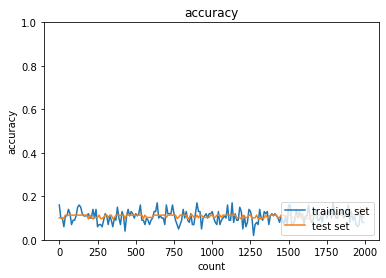

In [6]:
# パラメータの初期化
network = init_network()

accuracies_train = []
accuracies_test = []

for i in range(iters_num):
  # ランダムにバッチを取得
  batch_mask = np.random.choice(train_size, batch_size)
  # ミニバッチに対応する教師訓練用画像データを取得
  x_batch = x_train[batch_mask]
  # ミニバッチに対応する正解ラベルデータを取得
  d_batch = d_train[batch_mask]

  z1, z2, y = forward(network, x_batch)
  grad = backward(x_batch, d_batch, z1, z2, y, network)

  if (i + 1) % plot_interval == 0:
    accr_test = accuracy(x_test, d_test, network)
    accuracies_test.append(accr_test)
    accr_train = accuracy(x_batch, d_batch, network)
    accuracies_train.append(accr_train)

    print('Generation: '+ str(i+1) + '.正答率（train) = ' + str(accr_train))
    print('             :' + str(i+1) + '.正答率(test) =' + str(accr_test))

  # パラメータに勾配を適用
  for key in ('W1', 'W2', 'W3', 'b1', 'b2', 'b3'):
    network[key] -= learning_rate * grad[key]
  

lists = range(0, iters_num, plot_interval)
plt.plot(lists, accuracies_train, label='training set')
plt.plot(lists, accuracies_test, label='test set')
plt.legend(loc='lower right')
plt.title('accuracy')
plt.xlabel('count')
plt.ylabel('accuracy')
plt.ylim(0, 1.0)
# グラフの表示
plt.show()

活性化関数をReLUに変更 -gauss分布

In [7]:
import pickle
from PIL import Image

# mnistをロード
(x_train, d_train), (x_test, d_test) = load_mnist(normalize=True, one_hot_label=True)
train_size = len(x_train)

# 重み初期値補正係数
weight_init = 0.01
# 入力層サイズ
input_layer_size = 784
# 中間層サイズ
hidden_layer_1_size = 40
hidden_layer_2_size = 20

# 出力層サイズ
output_layer_size = 10
# 繰り返し数
iters_num = 2000
# ミニバッチサイズ
batch_size = 100

# 学習率
learning_rate = 0.1
# 描画頻度
plot_interval = 10

# 初期設定
def init_network():
  network = {}
  network['W1'] = weight_init * np.random.randn(input_layer_size, hidden_layer_1_size)
  network['W2'] = weight_init * np.random.randn(hidden_layer_1_size, hidden_layer_2_size)
  network['W3'] = weight_init * np.random.randn(hidden_layer_2_size, output_layer_size)

  network['b1'] = np.zeros(hidden_layer_1_size)
  network['b2'] = np.zeros(hidden_layer_2_size)
  network['b3'] = np.zeros(output_layer_size)

  return network

# 順伝播
def forward(network, x):
  W1, W2, W3 = network['W1'], network['W2'], network['W3']
  b1, b2, b3 = network['b1'], network['b2'], network['b3']
  # 活性化関数をReLUに変更
  hidden_f = functions.relu

  u1 = np.dot(x, W1) + b1
  z1 = hidden_f(u1)
  u2 = np.dot(z1, W2) + b2
  z2 = hidden_f(u2)
  u3 = np.dot(z2, W3) + b3
  y = functions.softmax(u3)

  return z1, z2, y

# 誤差逆伝播
def backward(x, d, z1, z2, y, network):
  grad = {}
  W1, W2, W3 = network['W1'], network['W2'], network['W3']
  b1, b2, b3 = network['b1'], network['b2'], network['b3']
  # 活性化関数をReLUに変更
  hidden_d_f = functions.d_relu
  last_d_f = functions.d_softmax_with_loss

  # 出力層でのデルタ
  delta3 = last_d_f(d, y)
  # b3の勾配
  grad['b3'] = np.sum(delta3, axis=0)
  # W3の勾配
  grad['W3'] = np.dot(z2.T, delta3)
  # 2層
  delta2 = np.dot(delta3, W3.T) * hidden_d_f(z2)
  grad['b2'] = np.sum(delta2, axis=0)
  grad['W2'] = np.dot(z1.T, delta2)

  # 1層
  delta1 = np.dot(delta2, W2.T) * hidden_d_f(z1)
  grad['b1'] = np.sum(delta1, axis=0)
  grad['W1'] = np.dot(x.T, delta1)

  return grad

# 正答率
def accuracy(x, d, network):
  z1, z2, y = forward(network, x)
  y = np.argmax(y, axis=1)
  if d.ndim != 1 : d = np.argmax(d, axis=1)
  accuracy = np.sum(y == d) / float(x.shape[0])
  return accuracy


Generation: 10.正答率（train) = 0.1
             :10.正答率(test) =0.1028
Generation: 20.正答率（train) = 0.16
             :20.正答率(test) =0.1135
Generation: 30.正答率（train) = 0.1
             :30.正答率(test) =0.1135
Generation: 40.正答率（train) = 0.13
             :40.正答率(test) =0.1135
Generation: 50.正答率（train) = 0.07
             :50.正答率(test) =0.1135
Generation: 60.正答率（train) = 0.09
             :60.正答率(test) =0.1135
Generation: 70.正答率（train) = 0.11
             :70.正答率(test) =0.1135
Generation: 80.正答率（train) = 0.11
             :80.正答率(test) =0.1135
Generation: 90.正答率（train) = 0.08
             :90.正答率(test) =0.1135
Generation: 100.正答率（train) = 0.11
             :100.正答率(test) =0.1135
Generation: 110.正答率（train) = 0.12
             :110.正答率(test) =0.1135
Generation: 120.正答率（train) = 0.11
             :120.正答率(test) =0.1135
Generation: 130.正答率（train) = 0.09
             :130.正答率(test) =0.1135
Generation: 140.正答率（train) = 0.12
             :140.正答率(test) =0.1135
Generation: 150.正答率（train) = 0.08
      

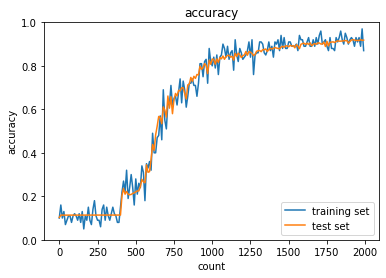

In [8]:
# パラメータの初期化
network = init_network()

accuracies_train = []
accuracies_test = []

for i in range(iters_num):
  # ランダムにバッチを取得
  batch_mask = np.random.choice(train_size, batch_size)
  # ミニバッチに対応する教師訓練用画像データを取得
  x_batch = x_train[batch_mask]
  # ミニバッチに対応する正解ラベルデータを取得
  d_batch = d_train[batch_mask]

  z1, z2, y = forward(network, x_batch)
  grad = backward(x_batch, d_batch, z1, z2, y, network)

  if (i + 1) % plot_interval == 0:
    accr_test = accuracy(x_test, d_test, network)
    accuracies_test.append(accr_test)
    accr_train = accuracy(x_batch, d_batch, network)
    accuracies_train.append(accr_train)

    print('Generation: '+ str(i+1) + '.正答率（train) = ' + str(accr_train))
    print('             :' + str(i+1) + '.正答率(test) =' + str(accr_test))

  # パラメータに勾配を適用
  for key in ('W1', 'W2', 'W3', 'b1', 'b2', 'b3'):
    network[key] -= learning_rate * grad[key]
  

lists = range(0, iters_num, plot_interval)
plt.plot(lists, accuracies_train, label='training set')
plt.plot(lists, accuracies_test, label='test set')
plt.legend(loc='lower right')
plt.title('accuracy')
plt.xlabel('count')
plt.ylabel('accuracy')
plt.ylim(0, 1.0)
# グラフの表示
plt.show()

sigmoid関数 - 重みの初期値をXavierに変更

Generation: 10.正答率（train) = 0.11
             :10.正答率(test) =0.1009
Generation: 20.正答率（train) = 0.09
             :20.正答率(test) =0.1013
Generation: 30.正答率（train) = 0.19
             :30.正答率(test) =0.2292
Generation: 40.正答率（train) = 0.14
             :40.正答率(test) =0.1313
Generation: 50.正答率（train) = 0.13
             :50.正答率(test) =0.1081
Generation: 60.正答率（train) = 0.21
             :60.正答率(test) =0.2366
Generation: 70.正答率（train) = 0.2
             :70.正答率(test) =0.2502
Generation: 80.正答率（train) = 0.18
             :80.正答率(test) =0.2589
Generation: 90.正答率（train) = 0.15
             :90.正答率(test) =0.1538
Generation: 100.正答率（train) = 0.25
             :100.正答率(test) =0.2362
Generation: 110.正答率（train) = 0.24
             :110.正答率(test) =0.2443
Generation: 120.正答率（train) = 0.4
             :120.正答率(test) =0.4631
Generation: 130.正答率（train) = 0.4
             :130.正答率(test) =0.4548
Generation: 140.正答率（train) = 0.3
             :140.正答率(test) =0.3155
Generation: 150.正答率（train) = 0.27
        

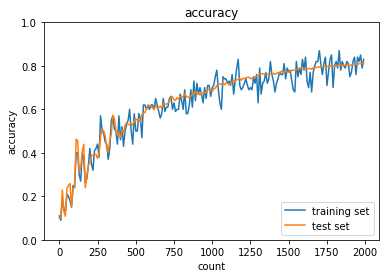

In [10]:
# mnistをロード
(x_train, d_train), (x_test, d_test) = load_mnist(normalize=True, one_hot_label=True)
train_size = len(x_train)

# 入力層サイズ
input_layer_size = 784
# 中間層サイズ
hidden_layer_1_size = 40
hidden_layer_2_size = 20

# 出力層サイズ
output_layer_size = 10
# 繰り返し数
iters_num = 2000
# ミニバッチサイズ
batch_size = 100

# 学習率
learning_rate = 0.1
# 描画頻度
plot_interval = 10

# 初期設定
def init_network():
  network = {}
  # Xavierの初期値に変更
  network['W1'] =np.random.randn(input_layer_size, hidden_layer_1_size) / (np.sqrt(input_layer_size))
  network['W2'] =np.random.randn(hidden_layer_1_size, hidden_layer_2_size) / (np.sqrt(hidden_layer_1_size))
  network['W3'] =np.random.randn(hidden_layer_2_size, output_layer_size) / (np.sqrt(hidden_layer_2_size))

  network['b1'] = np.zeros(hidden_layer_1_size)
  network['b2'] = np.zeros(hidden_layer_2_size)
  network['b3'] = np.zeros(output_layer_size)

  return network

# 順伝播
def forward(network, x):
  W1, W2, W3 = network['W1'], network['W2'], network['W3']
  b1, b2, b3 = network['b1'], network['b2'], network['b3']
  # 活性化関数:sigmoid
  hidden_f = functions.sigmoid

  u1 = np.dot(x, W1) + b1
  z1 = hidden_f(u1)
  u2 = np.dot(z1, W2) + b2
  z2 = hidden_f(u2)
  u3 = np.dot(z2, W3) + b3
  y = functions.softmax(u3)

  return z1, z2, y

# 誤差逆伝播
def backward(x, d, z1, z2, y, network):
  grad = {}
  W1, W2, W3 = network['W1'], network['W2'], network['W3']
  b1, b2, b3 = network['b1'], network['b2'], network['b3']
  # 活性化関数:sigmoid
  hidden_d_f = functions.d_sigmoid
  last_d_f = functions.d_softmax_with_loss

  # 出力層でのデルタ
  delta3 = last_d_f(d, y)
  # b3の勾配
  grad['b3'] = np.sum(delta3, axis=0)
  # W3の勾配
  grad['W3'] = np.dot(z2.T, delta3)
  # 2層
  delta2 = np.dot(delta3, W3.T) * hidden_d_f(z2)
  grad['b2'] = np.sum(delta2, axis=0)
  grad['W2'] = np.dot(z1.T, delta2)

  # 1層
  delta1 = np.dot(delta2, W2.T) * hidden_d_f(z1)
  grad['b1'] = np.sum(delta1, axis=0)
  grad['W1'] = np.dot(x.T, delta1)

  return grad

# 正答率
def accuracy(x, d, network):
  z1, z2, y = forward(network, x)
  y = np.argmax(y, axis=1)
  if d.ndim != 1 : d = np.argmax(d, axis=1)
  accuracy = np.sum(y == d) / float(x.shape[0])
  return accuracy


# パラメータの初期化
network = init_network()

accuracies_train = []
accuracies_test = []

for i in range(iters_num):
  # ランダムにバッチを取得
  batch_mask = np.random.choice(train_size, batch_size)
  # ミニバッチに対応する教師訓練用画像データを取得
  x_batch = x_train[batch_mask]
  # ミニバッチに対応する正解ラベルデータを取得
  d_batch = d_train[batch_mask]

  z1, z2, y = forward(network, x_batch)
  grad = backward(x_batch, d_batch, z1, z2, y, network)

  if (i + 1) % plot_interval == 0:
    accr_test = accuracy(x_test, d_test, network)
    accuracies_test.append(accr_test)
    accr_train = accuracy(x_batch, d_batch, network)
    accuracies_train.append(accr_train)

    print('Generation: '+ str(i+1) + '.正答率（train) = ' + str(accr_train))
    print('             :' + str(i+1) + '.正答率(test) =' + str(accr_test))

  # パラメータに勾配を適用
  for key in ('W1', 'W2', 'W3', 'b1', 'b2', 'b3'):
    network[key] -= learning_rate * grad[key]
  

lists = range(0, iters_num, plot_interval)
plt.plot(lists, accuracies_train, label='training set')
plt.plot(lists, accuracies_test, label='test set')
plt.legend(loc='lower right')
plt.title('accuracy')
plt.xlabel('count')
plt.ylabel('accuracy')
plt.ylim(0, 1.0)
# グラフの表示
plt.show()

活性化関数をReLU, 重みの初期値をHeに変更

Generation: 10.正答率（train) = 0.31
             :10.正答率(test) =0.3895
Generation: 20.正答率（train) = 0.57
             :20.正答率(test) =0.6241
Generation: 30.正答率（train) = 0.64
             :30.正答率(test) =0.7248
Generation: 40.正答率（train) = 0.79
             :40.正答率(test) =0.7549
Generation: 50.正答率（train) = 0.74
             :50.正答率(test) =0.7474
Generation: 60.正答率（train) = 0.8
             :60.正答率(test) =0.8177
Generation: 70.正答率（train) = 0.79
             :70.正答率(test) =0.8104
Generation: 80.正答率（train) = 0.86
             :80.正答率(test) =0.8477
Generation: 90.正答率（train) = 0.86
             :90.正答率(test) =0.8393
Generation: 100.正答率（train) = 0.86
             :100.正答率(test) =0.8686
Generation: 110.正答率（train) = 0.82
             :110.正答率(test) =0.8569
Generation: 120.正答率（train) = 0.81
             :120.正答率(test) =0.8338
Generation: 130.正答率（train) = 0.86
             :130.正答率(test) =0.8629
Generation: 140.正答率（train) = 0.9
             :140.正答率(test) =0.8785
Generation: 150.正答率（train) = 0.87
      

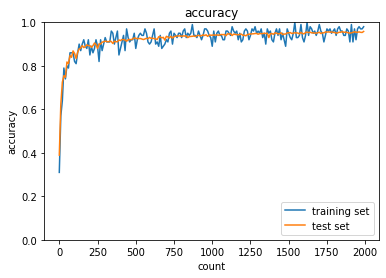

In [11]:
# mnistをロード
(x_train, d_train), (x_test, d_test) = load_mnist(normalize=True, one_hot_label=True)
train_size = len(x_train)

# 入力層サイズ
input_layer_size = 784
# 中間層サイズ
hidden_layer_1_size = 40
hidden_layer_2_size = 20

# 出力層サイズ
output_layer_size = 10
# 繰り返し数
iters_num = 2000
# ミニバッチサイズ
batch_size = 100

# 学習率
learning_rate = 0.1
# 描画頻度
plot_interval = 10

# 初期設定
def init_network():
  network = {}
  # Xavierの初期値に変更
  network['W1'] =np.random.randn(input_layer_size, hidden_layer_1_size) / (np.sqrt(input_layer_size)) * np.sqrt(2)
  network['W2'] =np.random.randn(hidden_layer_1_size, hidden_layer_2_size) / (np.sqrt(hidden_layer_1_size)) * np.sqrt(2)
  network['W3'] =np.random.randn(hidden_layer_2_size, output_layer_size) / (np.sqrt(hidden_layer_2_size)) * np.sqrt(2)

  network['b1'] = np.zeros(hidden_layer_1_size)
  network['b2'] = np.zeros(hidden_layer_2_size)
  network['b3'] = np.zeros(output_layer_size)

  return network

# 順伝播
def forward(network, x):
  W1, W2, W3 = network['W1'], network['W2'], network['W3']
  b1, b2, b3 = network['b1'], network['b2'], network['b3']
  # 活性化関数:ReLU
  hidden_f = functions.relu

  u1 = np.dot(x, W1) + b1
  z1 = hidden_f(u1)
  u2 = np.dot(z1, W2) + b2
  z2 = hidden_f(u2)
  u3 = np.dot(z2, W3) + b3
  y = functions.softmax(u3)

  return z1, z2, y

# 誤差逆伝播
def backward(x, d, z1, z2, y, network):
  grad = {}
  W1, W2, W3 = network['W1'], network['W2'], network['W3']
  b1, b2, b3 = network['b1'], network['b2'], network['b3']
  # 活性化関数:ReLU
  hidden_d_f = functions.d_relu
  last_d_f = functions.d_softmax_with_loss

  # 出力層でのデルタ
  delta3 = last_d_f(d, y)
  # b3の勾配
  grad['b3'] = np.sum(delta3, axis=0)
  # W3の勾配
  grad['W3'] = np.dot(z2.T, delta3)
  # 2層
  delta2 = np.dot(delta3, W3.T) * hidden_d_f(z2)
  grad['b2'] = np.sum(delta2, axis=0)
  grad['W2'] = np.dot(z1.T, delta2)

  # 1層
  delta1 = np.dot(delta2, W2.T) * hidden_d_f(z1)
  grad['b1'] = np.sum(delta1, axis=0)
  grad['W1'] = np.dot(x.T, delta1)

  return grad

# 正答率
def accuracy(x, d, network):
  z1, z2, y = forward(network, x)
  y = np.argmax(y, axis=1)
  if d.ndim != 1 : d = np.argmax(d, axis=1)
  accuracy = np.sum(y == d) / float(x.shape[0])
  return accuracy


# パラメータの初期化
network = init_network()

accuracies_train = []
accuracies_test = []

for i in range(iters_num):
  # ランダムにバッチを取得
  batch_mask = np.random.choice(train_size, batch_size)
  # ミニバッチに対応する教師訓練用画像データを取得
  x_batch = x_train[batch_mask]
  # ミニバッチに対応する正解ラベルデータを取得
  d_batch = d_train[batch_mask]

  z1, z2, y = forward(network, x_batch)
  grad = backward(x_batch, d_batch, z1, z2, y, network)

  if (i + 1) % plot_interval == 0:
    accr_test = accuracy(x_test, d_test, network)
    accuracies_test.append(accr_test)
    accr_train = accuracy(x_batch, d_batch, network)
    accuracies_train.append(accr_train)

    print('Generation: '+ str(i+1) + '.正答率（train) = ' + str(accr_train))
    print('             :' + str(i+1) + '.正答率(test) =' + str(accr_test))

  # パラメータに勾配を適用
  for key in ('W1', 'W2', 'W3', 'b1', 'b2', 'b3'):
    network[key] -= learning_rate * grad[key]
  

lists = range(0, iters_num, plot_interval)
plt.plot(lists, accuracies_train, label='training set')
plt.plot(lists, accuracies_test, label='test set')
plt.legend(loc='lower right')
plt.title('accuracy')
plt.xlabel('count')
plt.ylabel('accuracy')
plt.ylim(0, 1.0)
# グラフの表示
plt.show()